# Setup BART and View on Google Colab

In [ ]:
import os

if os.getenv("COLAB_RELEASE_TAG"):
  os.environ["COLAB"] = "1"
else:
  os.environ["COLAB"] = "0"

In [3]:
%%bash

[ $COLAB -ne 1 ] && echo "Skipp cell (not on Colab)" && exit 0

# Install BARTs dependencies
apt-get install -y make gcc libfftw3-dev liblapacke-dev libpng-dev libopenblas-dev &> /dev/null

# Install additional dependencies for converting ISMRMRD files
apt-get install -y libismrmrd-dev libboost-all-dev libhdf5-serial-dev &> /dev/null

# Install dependencies for view
apt-get install -y libgtk-3-dev &> /dev/null

# Install inkscape
apt-get install -y inkscape &> /dev/null




In [8]:
%%bash

[ $COLAB -ne 1 ] && echo "Skipp cell (not on Colab)" && exit 0

# Clone Bart
[ -d bart ] && rm -r bart

git clone https://github.com/mrirecon/bart/ bart &> /dev/null

cd bart

git checkout v0.9.00

# Define compile options
COMPILE_SPECS=" ISMRMRD=1"

printf "%s\n" $COMPILE_SPECS > Makefiles/Makefile.local

make &> /dev/null

Note: switching to 'v0.9.00'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

HEAD is now at 672a840f bump version


In [10]:
import os
import sys

if os.environ["COLAB"] == "1":
  os.environ['BART_TOOLBOX_PATH']=os.getcwd()+"/bart/"
  os.environ['PATH'] = os.environ['BART_TOOLBOX_PATH'] + ":" + os.environ['PATH']
  os.environ['PATH'] = os.getcwd()+"/view/" + ":" + os.environ['PATH']
  sys.path.append(os.environ['BART_TOOLBOX_PATH'] + "/python/")

In [11]:
%%bash

[ $COLAB -ne 1 ] && echo "Skipp cell (not on Colab)" && exit 0

# Clone Bart
[ -d view ] && rm -r view

git clone https://github.com/mrirecon/view.git view &> /dev/null

cd view

git checkout v0.3.00

make &> /dev/null

Note: switching to 'v0.3.00'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

HEAD is now at 460e4ca change BART path


In [16]:
%%bash

bart phantom phan
cfl2png -x1 -y0 phan phan

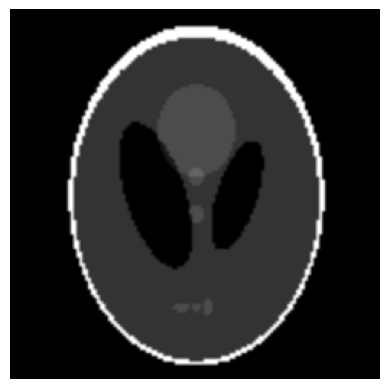

In [17]:

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread('phan.png')
plt.imshow(img)
plt.axis('off')
plt.show()

# Part A: Coronal Proton Density Dataset

### Download Dataset

In [ ]:
%%bash

if [ ! -f ksp.h5 ]; then
	wget -O ksp.h5 http://mridata.org/download/993716e9-b5f0-4c30-a059-c003182d0f9c >/dev/null  # download data from mridata.org
	bart ismrmrd --interleaved-siemens -o0 ksp.h5 ksp_vol
fi

### Generate RSS Reference and Undersampled k-Space

In [19]:
%%bash

bart poisson -C24 -Y368 -y4 -Z24 tmp
bart slice 2 0 tmp pat

bart repmat 0 320 pat tmp
cfl2png -x1 -y0 tmp pat

bart slice 13 20 ksp_vol tmp
bart scale 40000. tmp tmp
bart fmac tmp pat ksp_raw

bart fft -i -u 3 tmp cim_os
bart ecalib -m1 tmp col
bart fmac -C -s8 cim_os col img
bart flip 1 img img

bart resize -c 0 320 1 320 img img
bart rss 8 img rss

cfl2png -A -u10 -x1 -y0 rss rss


points: 2636, grid size: 368x24 = 8832 (R = 3.350531)
Done.


### Joint Pre-Processing

In [20]:
%%bash

# Remove frequency oversampling
bart fft -u -i 1 ksp_raw tmp
bart resize -c 0 320 tmp tmp
bart fft -u 1 tmp ksp_nos

### Generate Reference PICS Reconstruction

In [21]:
%%bash

POST=_rec

# Estimate Coil Sensitivities
bart ecalib -m1 ksp_raw tmp
bart resize -c 0 320 tmp col

# Perform PICS reconstruction
bart pics -S -RW:3:0:0.005 -i100 ksp_nos col img
bart flip 1 img img

# Take magnitude
bart rss 0 img rss$POST

# Remove phase oversampling
bart resize -c 0 320 1 320 rss$POST rss$POST

# Compute difference
bart saxpy -- -1 rss rss$POST diff$POST
bart rss 0 diff$POST diff$POST

cfl2png -A -u10  -x1 -y0 rss$POST rss$POST
cfl2png -A -u0.5 -x1 -y0 diff$POST diff$POST

Done.
Size: 117760 Samples: 31360 Acc: 3.76
l1-wavelet regularization: 0.005000
Regularization terms: 1, Supporting variables: 0
FISTA
Total Time: 11.768360


### Parameter of ESPIRiT not specified
Here we use auto instead of default parameter

In [ ]:
%%bash

POST=_coils

# Estimate Coil Sensitivities
bart ecalib -a -m1 ksp_raw tmp
bart resize -c 0 320 tmp col

# Perform PICS reconstruction
bart pics -S -RW:3:0:0.005 -i100 ksp_nos col img
bart flip 1 img img

# Take magnitude
bart rss 0 img rss$POST

# Remove phase oversampling
bart resize -c 0 320 1 320 rss$POST rss$POST

# Compute difference
bart saxpy -- -1 rss_rec rss$POST diff$POST
bart rss 0 diff$POST diff$POST

cfl2png -A -u10 -x1 -y0 rss$POST rss$POST
cfl2png -A -u0.5  -x1 -y0 diff$POST diff$POST

### Algorithm Not Specified
Here we use ADMM instead of FISTA

In [23]:
%%bash

POST=_algo

# Estimate Coil Sensitivities
bart ecalib -m1 ksp_raw tmp
bart resize -c 0 320 tmp col

# Perform PICS reconstruction
bart pics -S -RW:3:0:0.005 -i100 -m ksp_nos col img
bart flip 1 img img

# Take magnitude
bart rss 0 img rss$POST

# Remove phase oversampling
bart resize -c 0 320 1 320 rss$POST rss$POST

# Compute difference
bart saxpy -- -1 rss_rec rss$POST diff$POST

cfl2png -A -u10  -x1 -y0 rss$POST rss$POST
cfl2png -A -u0.5 -x1 -y0 diff$POST diff$POST

Done.
Size: 117760 Samples: 31360 Acc: 3.76
l1-wavelet regularization: 0.005000
Regularization terms: 1, Supporting variables: 0
ADMM
Total Time: 18.563206


### Iterations not specified
Here we use 50 instead of 100

In [24]:
%%bash

POST=_iter

# Estimate Coil Sensitivities
bart ecalib -m1 ksp_raw tmp
bart resize -c 0 320 tmp col

# Perform PICS reconstruction
bart pics -S -RW:3:0:0.005 -i50 ksp_nos col img
bart flip 1 img img

# Take magnitude
bart rss 0 img rss$POST

# Remove phase oversampling
bart resize -c 0 320 1 320 rss$POST rss$POST

# Compute difference
bart saxpy -- -1 rss_rec rss$POST diff$POST
bart rss 0 diff$POST diff$POST

cfl2png -A -u10  -x1 -y0 rss$POST rss$POST
cfl2png -A -u0.5 -x1 -y0 diff$POST diff$POST


Done.
Size: 117760 Samples: 31360 Acc: 3.76
l1-wavelet regularization: 0.005000
Regularization terms: 1, Supporting variables: 0
FISTA
Total Time: 7.045927


### Normalization not specified
Here we use raw data by 40000 instead of a the Maximum magnitude of the low resolution RSS

In [25]:
%%bash

POST=_norm

# Estimate Coil Sensitivities
bart ecalib -m1 ksp_raw tmp
bart resize -c 0 320 tmp col

# Perform PICS reconstruction
bart pics -S -w1 -RW:3:0:0.005 -i100 ksp_nos col img
bart flip 1 img img

# Take magnitude
bart rss 0 img rss$POST

# Remove phase oversampling
bart resize -c 0 320 1 320 rss$POST rss$POST

# Compute difference
bart saxpy -- -1 rss_rec rss$POST diff$POST
bart rss 0 diff$POST diff$POST

cfl2png -A -u10 -x1 -y0 rss$POST rss$POST
cfl2png -A -u0.5  -x1 -y0 diff$POST diff$POST

Done.
Size: 117760 Samples: 31360 Acc: 3.76
l1-wavelet regularization: 0.005000
Regularization terms: 1, Supporting variables: 0
FISTA
Total Time: 11.634146


# Part B: Coronal Proton Density Fat Suppressed

### Download Dataset

In [ ]:
%%bash

if [ ! -f ksp_fs.h5 ]; then
	wget -O ksp_fs.h5 http://mridata.org/download/6c10376d-2825-4275-9d37-7cbac95b73d1 >/dev/null  # download data from mridata.org
	bart ismrmrd --interleaved-siemens -o0 ksp_fs.h5 ksp_fs_vol
fi

### Generate RSS Reference and Undersampled k-Space

In [27]:
%%bash

bart upat -c 12 -Y368 -y3 -Z1 pat_fs
bart repmat 0 320 pat_fs tmp
cfl2png -x1 -y0 tmp pat_fs

bart slice 13 20 ksp_fs_vol tmp
bart scale 40000. tmp tmp
bart fmac tmp pat_fs ksp_fs_raw

bart fft -i -u 3 tmp cim_os
bart ecalib -m1 tmp col
bart fmac -C -s8 cim_os col img

bart resize -c 0 320 1 320 img img
bart flip 1 img img
bart rss 8 img rss_fs

cfl2png -A -u3 -x1 -y0 rss_fs rss_fs


Done.


### Joint Preprocessing

In [28]:
%%bash

# Remove frequency oversampling
bart fft -u -i 1 ksp_fs_raw tmp
bart resize -c 0 320 tmp tmp
bart fft -u 1 tmp ksp_fs_nos

### Generate Reference PICS Reconstruction

In [29]:
%%bash

POST=_rec

# Estimate Coil Sensitivities
bart ecalib -m1 ksp_fs_raw tmp
bart resize -c 0 320 tmp col

# Perform PICS reconstruction
bart pics -S -RW:3:0:0.01 -i100 ksp_fs_nos col img
bart flip 1 img img

# Take magnitude
bart rss 0 img rss_fs$POST

# Remove phase oversampling
bart resize -c 0 320 1 320 rss_fs$POST rss_fs$POST

# Compute difference
bart saxpy -- -1 rss_fs rss_fs$POST diff_fs$POST
bart rss 0 diff_fs$POST diff_fs$POST

cfl2png -A -u3 -x1 -y0 rss_fs$POST rss_fs$POST
cfl2png -A -u0.15 -x1 -y0 diff_fs$POST diff_fs$POST

Done.
Size: 117760 Samples: 40319 Acc: 2.92
l1-wavelet regularization: 0.010000
Regularization terms: 1, Supporting variables: 0
FISTA
Total Time: 9.899563


### Parameter of ESPIRiT not specified
Here we use auto instead of default parameter

In [30]:
%%bash

POST=_coils

# Estimate Coil Sensitivities
bart ecalib -a -m1 ksp_fs_raw tmp
bart resize -c 0 320 tmp col

# Perform PICS reconstruction
bart pics -S -RW:3:0:0.01 -i100 ksp_fs_nos col img
bart flip 1 img img

# Take magnitude
bart rss 0 img rss_fs$POST

# Remove phase oversampling
bart resize -c 0 320 1 320 rss_fs$POST rss_fs$POST

# Compute difference
bart saxpy -- -1 rss_fs_rec rss_fs$POST diff_fs$POST
bart rss 0 diff_fs$POST diff_fs$POST

cfl2png -A -u3    -x1 -y0 rss_fs$POST rss_fs$POST
cfl2png -A -u0.15 -x1 -y0 diff_fs$POST diff_fs$POST

---------------------------------------------
| CTR1 | CTR2 |  Crop  |      Est. MSE      |
---------------------------------------------
|    1 |    1 | 0.9900 | 4.464030468750e+04 |
|      |    2 | 0.8900 | 3.290894531250e+03 |
|      |    3 | 0.7900 | 3.712403076172e+03 |
|    2 |    1 | 0.8400 | 3.494414550781e+03 |
|      |    2 | 0.8900 | 3.290894531250e+03 |
|      |    3 | 0.9400 | 3.089489013672e+03 |
|      |    4 | 0.9900 | 4.464030468750e+04 |
|    3 |    1 | 0.9650 | 3.285995361328e+03 |
|      |    2 | 0.9400 | 3.089489013672e+03 |
|      |    3 | 0.9150 | 3.172969970703e+03 |
|    4 |    1 | 0.9275 | 3.127450683594e+03 |
|      |    2 | 0.9400 | 3.089489013672e+03 |
|      |    3 | 0.9525 | 3.072914550781e+03 |
|      |    4 | 0.9650 | 3.285995361328e+03 |
|    5 |    1 | 0.9587 | 3.118624755859e+03 |
|      |    2 | 0.9525 | 3.072914550781e+03 |
|      |    3 | 0.9462 | 3.072938720703e+03 |
|    6 |    1 | 0.9494 | 3.070088867188e+03 |
|      |    2 | 0.9525 | 3.0729145

### Algorithm Not Specified
Here we use ADMM instead of FISTA

In [31]:
%%bash

POST=_algo

# Estimate Coil Sensitivities
bart ecalib -m1 ksp_fs_raw tmp
bart resize -c 0 320 tmp col

# Perform PICS reconstruction
bart pics -S -RW:3:0:0.01 -i100 -m ksp_fs_nos col img
bart flip 1 img img

# Take magnitude
bart rss 0 img rss_fs$POST

# Remove phase oversampling
bart resize -c 0 320 1 320 rss_fs$POST rss_fs$POST

# Compute difference
bart saxpy -- -1 rss_fs_rec rss_fs$POST diff_fs$POST
bart rss 0 diff_fs$POST diff_fs$POST

cfl2png -A -u3 -x1 -y0 rss_fs$POST rss_fs$POST
cfl2png -A -u0.15 -x1 -y0 diff_fs$POST diff_fs$POST



Done.
Size: 117760 Samples: 40319 Acc: 2.92
l1-wavelet regularization: 0.010000
Regularization terms: 1, Supporting variables: 0
ADMM
Total Time: 14.881110


### Iterations not specified
Here we use 50 instead of 100

In [32]:
%%bash

POST=_iter

# Estimate Coil Sensitivities
bart ecalib -m1 ksp_fs_raw tmp
bart resize -c 0 320 tmp col

# Perform PICS reconstruction
bart pics -S -RW:3:0:0.01 -i50 ksp_fs_nos col img
bart flip 1 img img

# Take magnitude
bart rss 0 img rss_fs$POST

# Remove phase oversampling
bart resize -c 0 320 1 320 rss_fs$POST rss_fs$POST

# Compute difference
bart saxpy -- -1 rss_fs_rec rss_fs$POST diff_fs$POST
bart rss 0 diff_fs$POST diff_fs$POST

cfl2png -A -u3 -x1 -y0 rss_fs$POST rss_fs$POST
cfl2png -A -u0.15 -x1 -y0 diff_fs$POST diff_fs$POST


Done.
Size: 117760 Samples: 40319 Acc: 2.92
l1-wavelet regularization: 0.010000
Regularization terms: 1, Supporting variables: 0
FISTA
Total Time: 6.183155


### Normalization not specified
Here we use raw data by 40000 instead of a the Maximum magnitude of the low resolution RSS

In [33]:
%%bash

POST=_norm

# Estimate Coil Sensitivities
bart ecalib -m1 ksp_fs_raw tmp
bart resize -c 0 320 tmp col

# Perform PICS reconstruction
bart pics -S -w1. -RW:3:0:0.01 -i100 ksp_fs_nos col img
bart flip 1 img img

# Take magnitude
bart rss 0 img rss_fs$POST

# Remove phase oversampling
bart resize -c 0 320 1 320 rss_fs$POST rss_fs$POST

# Compute difference
bart saxpy -- -1 rss_fs_rec rss_fs$POST diff_fs$POST
bart rss 0 diff_fs$POST diff_fs$POST

cfl2png -A -u3 -x1 -y0 rss_fs$POST rss_fs$POST
cfl2png -A -u0.15 -x1 -y0 diff_fs$POST diff_fs$POST

Done.
Size: 117760 Samples: 40319 Acc: 2.92
l1-wavelet regularization: 0.010000
Regularization terms: 1, Supporting variables: 0
FISTA
Total Time: 10.465305


# Merge PNGs with Inkscape

FIXME: To run on Colab, we need to copy the template to this directory / Adapt pathes

In [ ]:
%%bash

inkscape --export-filename=fig.pdf ../figures/Fig_X_Reconstruction_Template.svg
inkscape --export-filename=fig.png ../figures/Fig_X_Reconstruction_Template.svg

Failed to get connection
** (inkscape:72750): CRITICAL **: 14:54:36.825: dbus_g_proxy_new_for_name: assertion 'connection != NULL' failed

** (inkscape:72750): CRITICAL **: 14:54:36.825: dbus_g_proxy_call: assertion 'DBUS_IS_G_PROXY (proxy)' failed

** (inkscape:72750): CRITICAL **: 14:54:36.825: dbus_g_connection_register_g_object: assertion 'connection != NULL' failed
Failed to get connection
** (inkscape:72774): CRITICAL **: 14:54:38.811: dbus_g_proxy_new_for_name: assertion 'connection != NULL' failed

** (inkscape:72774): CRITICAL **: 14:54:38.811: dbus_g_proxy_call: assertion 'DBUS_IS_G_PROXY (proxy)' failed

** (inkscape:72774): CRITICAL **: 14:54:38.811: dbus_g_connection_register_g_object: assertion 'connection != NULL' failed
Background RRGGBBAA: ffffff00
Area 0:0:720.763:499.55 exported to 721 x 500 pixels (96 dpi)


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread('fig.png')
plt.imshow(img)
plt.axis('off')
plt.show()